DSCI552 HW8

Name: Ashley Chen

GitHub username: ash54x

USC ID: 8562317194

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from scipy.special import softmax

1. Supervised, Semi-Supervised, and Unsupervised Learning

(a) Load Data

In [2]:
columns = ['ID', 'diagnosis'] + [f'features_{i}' for i in range(1, 31)]
df = pd.read_csv('wdbc.data', header=None, names=columns)
df['diagnosis'].replace({'M': 1, 'B': 0}, inplace=True)
df.drop(columns='ID', inplace=True)
df.head()

,diagnosis,features_1,features_2,features_3,features_4,features_5,features_6,features_7,features_8,features_9,...,features_21,features_22,features_23,features_24,features_25,features_26,features_27,features_28,features_29,features_30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


(b) Monte-Carlo Simulation

i. Supervised Learning

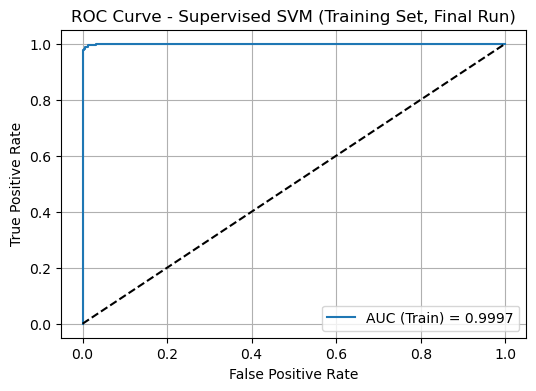

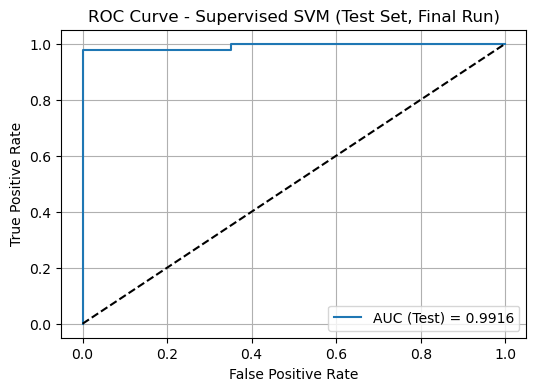


Confusion Matrix (Training Data):
[[284   2]
 [  2 168]]

Confusion Matrix (Testing Data):
[[68  3]
 [ 1 41]]
 Accuracy  Precision   Recall  F1-score      AUC
 0.955752   0.956117 0.955752  0.955856 0.997988
 0.982301   0.982301 0.982301  0.982301 0.995305
 0.982301   0.982301 0.982301  0.982301 0.998994
 0.964602   0.964602 0.964602  0.964602 0.963447
 0.946903   0.947999 0.946903  0.947141 0.980550
 0.946903   0.947999 0.946903  0.947141 0.963112
 0.938053   0.940350 0.938053  0.937146 0.991281
 0.991150   0.991356 0.991150  0.991171 0.999329
 0.973451   0.975221 0.973451  0.973623 0.999665
 0.955752   0.958663 0.955752  0.955104 0.994634
 0.973451   0.973481 0.973451  0.973384 0.995641
 0.982301   0.982786 0.982301  0.982208 0.996647
 0.955752   0.956507 0.955752  0.955391 0.995641
 0.911504   0.912892 0.911504  0.911901 0.964118
 0.973451   0.973481 0.973451  0.973384 0.988934
 0.955752   0.956117 0.955752  0.955856 0.992287
 0.929204   0.929204 0.929204  0.929204 0.984909
 0.9823

In [3]:
def supervised_learning(df, M=30):
    normalizer = Normalizer()
    results = []

    for seed in range(M):
        np.random.seed(seed)
        malignant = df[df['diagnosis'] == 1]
        benign = df[df['diagnosis'] == 0]

        test_m = malignant.sample(frac=0.2, random_state=seed)
        test_b = benign.sample(frac=0.2, random_state=seed)

        test_set = pd.concat([test_m, test_b])
        train_set = df.drop(test_set.index)

        X_train = normalizer.fit_transform(train_set.iloc[:, 1:])
        y_train = train_set['diagnosis'].values
        X_test = normalizer.transform(test_set.iloc[:, 1:])
        y_test = test_set['diagnosis'].values

        svc = LinearSVC(penalty='l1', dual=False, max_iter=10000)
        grid = GridSearchCV(
            svc,
            param_grid={'C': np.logspace(-2, 7, 20)},
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
            scoring='f1'
        )
        grid.fit(X_train, y_train)

        best_svm = grid.best_estimator_

        y_train_pred = best_svm.predict(X_train)
        y_test_pred = best_svm.predict(X_test)

        y_train_score = best_svm.decision_function(X_train)
        y_test_score = best_svm.decision_function(X_test)

        train_report = classification_report(y_train, y_train_pred, output_dict=True)
        test_report = classification_report(y_test, y_test_pred, output_dict=True)

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
        auc_train = auc(fpr_train, tpr_train)
        auc_test = auc(fpr_test, tpr_test)

        results.append({
            'Accuracy': test_report['accuracy'],
            'Precision': test_report['weighted avg']['precision'],
            'Recall': test_report['weighted avg']['recall'],
            'F1-score': test_report['weighted avg']['f1-score'],
            'AUC': auc_test
        })

        if seed == M - 1:
            final_cm_train = confusion_matrix(y_train, y_train_pred)
            final_cm_test = confusion_matrix(y_test, y_test_pred)
            final_fpr_train, final_tpr_train = fpr_train, tpr_train
            final_fpr_test, final_tpr_test = fpr_test, tpr_test

    return pd.DataFrame(results), final_cm_train, final_cm_test, final_fpr_train, final_tpr_train, final_fpr_test, final_tpr_test

supervised_results, cm_train, cm_test, fpr_train, tpr_train, fpr_test, tpr_test = supervised_learning(df)

plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label=f'AUC (Train) = {auc(fpr_train, tpr_train):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Supervised SVM (Training Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(fpr_test, tpr_test, label=f'AUC (Test) = {auc(fpr_test, tpr_test):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Supervised SVM (Test Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

print("\nConfusion Matrix (Training Data):")
print(cm_train)

print("\nConfusion Matrix (Testing Data):")
print(cm_test)

print(supervised_results.to_string(index=False))

ii. Semi-Supervised Learning

In [ ]:
def semi_supervised_learning(df, M=30):
    normalizer = Normalizer()
    results = []

    for seed in range(M):
        np.random.seed(seed)
        malignant = df[df['diagnosis'] == 1]
        benign = df[df['diagnosis'] == 0]

        test_m = malignant.sample(frac=0.2, random_state=seed)
        test_b = benign.sample(frac=0.2, random_state=seed)
        test_set = pd.concat([test_m, test_b])
        train_set = df.drop(test_set.index)

        X = normalizer.fit_transform(train_set.iloc[:, 2:])
        y = train_set['diagnosis'].values
        X_test = normalizer.transform(test_set.iloc[:, 2:])
        y_test = test_set['diagnosis'].values

        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]
        np.random.shuffle(pos_idx)
        np.random.shuffle(neg_idx)

        labeled_idx = np.concatenate([
            pos_idx[:len(pos_idx)//2],
            neg_idx[:len(neg_idx)//2]
        ])
        unlabeled_idx = np.setdiff1d(np.arange(len(y)), labeled_idx)

        X_labeled = X[labeled_idx]
        y_labeled = y[labeled_idx]
        X_unlabeled = X[unlabeled_idx]

        base_svm = LinearSVC(penalty='l1', dual=False, max_iter=5000)
        param_grid = {'C': np.logspace(-2, 2, 5)}
        grid = GridSearchCV(base_svm, param_grid, cv=5, scoring='f1')
        grid.fit(X_labeled, y_labeled)

        model = clone(grid.best_estimator_)
        model.fit(X_labeled, y_labeled)

        while len(X_unlabeled) > 0:
            scores = model.decision_function(X_unlabeled)
            idx_farthest = np.argmax(np.abs(scores))
            x_farthest = X_unlabeled[idx_farthest].reshape(1, -1)
            y_pseudo = model.predict(x_farthest)

            X_labeled = np.vstack([X_labeled, x_farthest])
            y_labeled = np.append(y_labeled, y_pseudo)
            X_unlabeled = np.delete(X_unlabeled, idx_farthest, axis=0)

            model.fit(X_labeled, y_labeled)

        y_train_pred = model.predict(X)
        y_train_score = model.decision_function(X)

        y_test_pred = model.predict(X_test)
        y_test_score = model.decision_function(X_test)

        report_test = classification_report(y_test, y_test_pred, output_dict=True)
        report_train = classification_report(y, y_train_pred, output_dict=True)

        fpr_train, tpr_train, _ = roc_curve(y, y_train_score)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)

        auc_train = auc(fpr_train, tpr_train)
        auc_test = auc(fpr_test, tpr_test)

        results.append({
            'Accuracy': report_test['accuracy'],
            'Precision': report_test['weighted avg']['precision'],
            'Recall': report_test['weighted avg']['recall'],
            'F1-score': report_test['weighted avg']['f1-score'],
            'AUC': auc_test
        })

        if seed == M - 1:
            final_cm_train = confusion_matrix(y, y_train_pred)
            final_cm_test = confusion_matrix(y_test, y_test_pred)
            final_fpr_train, final_tpr_train = fpr_train, tpr_train
            final_fpr_test, final_tpr_test = fpr_test, tpr_test

    return pd.DataFrame(results), final_cm_train, final_cm_test, final_fpr_train, final_tpr_train, final_fpr_test, final_tpr_test

semi_supervised_results, semi_cm_train, semi_cm_test, semi_fpr_train, semi_tpr_train, semi_fpr_test, semi_tpr_test = semi_supervised_learning(df)

plt.figure(figsize=(6, 4))
plt.plot(semi_fpr_train, semi_tpr_train, label=f'AUC (Train) = {auc(semi_fpr_train, semi_tpr_train):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Semi-Supervised SVM (Training Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(semi_fpr_test, semi_tpr_test, label=f'AUC (Test) = {auc(semi_fpr_test, semi_tpr_test):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Semi-Supervised SVM (Test Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

print("\nConfusion Matrix (Training Data):")
print(semi_cm_train)

print("\nConfusion Matrix (Testing Data):")
print(semi_cm_test)

print(semi_supervised_results.to_string(index=False))

iii. Unsupervised Learning

In [ ]:
def unsupervised_learning_kmeans(df, M=30):
    normalizer = Normalizer()
    results = []

    for seed in range(M):
        np.random.seed(seed)
        malignant = df[df['diagnosis'] == 1]
        benign = df[df['diagnosis'] == 0]

        test_m = malignant.sample(frac=0.2, random_state=seed)
        test_b = benign.sample(frac=0.2, random_state=seed)

        test_set = pd.concat([test_m, test_b])
        train_set = df.drop(test_set.index)

        X_train = normalizer.fit_transform(train_set.iloc[:, 2:])
        y_train = train_set['diagnosis'].values
        X_test = normalizer.transform(test_set.iloc[:, 2:])
        y_test = test_set['diagnosis'].values

        kmeans = KMeans(n_clusters=2, n_init=15, random_state=seed)
        cluster_labels = kmeans.fit_predict(X_train)

        centers = kmeans.cluster_centers_
        distances = np.linalg.norm(X_train[:, np.newaxis] - centers, axis=2)

        majority_labels = {}
        for i in range(2):
            idx_closest = np.argsort(distances[:, i])[:30]
            majority_vote = np.bincount(y_train[idx_closest]).argmax()
            majority_labels[i] = majority_vote

        y_train_pred = np.array([majority_labels[label] for label in cluster_labels])

        test_distances = np.linalg.norm(X_test[:, np.newaxis] - centers, axis=2)
        test_cluster_labels = np.argmin(test_distances, axis=1)
        y_test_pred = np.array([majority_labels[label] for label in test_cluster_labels])

        prob_train = softmax(-distances, axis=1)[:, majority_labels[1]]
        prob_test = softmax(-test_distances, axis=1)[:, majority_labels[1]]

        report_train = classification_report(y_train, y_train_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)

        fpr_train, tpr_train, _ = roc_curve(y_train, prob_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, prob_test)

        auc_train = auc(fpr_train, tpr_train)
        auc_test = auc(fpr_test, tpr_test)

        results.append({
            'Accuracy': report_test['accuracy'],
            'Precision': report_test['weighted avg']['precision'],
            'Recall': report_test['weighted avg']['recall'],
            'F1-score': report_test['weighted avg']['f1-score'],
            'AUC': auc_test
        })

        if seed == M - 1:
            final_cm_train = confusion_matrix(y_train, y_train_pred)
            final_cm_test = confusion_matrix(y_test, y_test_pred)
            final_fpr_train, final_tpr_train = fpr_train, tpr_train
            final_fpr_test, final_tpr_test = fpr_test, tpr_test

    return pd.DataFrame(results), final_cm_train, final_cm_test, final_fpr_train, final_tpr_train, final_fpr_test, final_tpr_test

unsupervised_results, unsup_cm_train, unsup_cm_test, unsup_fpr_train, unsup_tpr_train, unsup_fpr_test, unsup_tpr_test = unsupervised_learning_kmeans(df)

plt.figure(figsize=(6, 4))
plt.plot(unsup_fpr_train, unsup_tpr_train, label=f'AUC (Train) = {auc(unsup_fpr_train, unsup_tpr_train):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Unsupervised KMeans (Training Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(unsup_fpr_test, unsup_tpr_test, label=f'AUC (Test) = {auc(unsup_fpr_test, unsup_tpr_test):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Unsupervised KMeans (Test Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

print("\nConfusion Matrix (Training Data):")
print(unsup_cm_train)

print("\nConfusion Matrix (Testing Data):")
print(unsup_cm_test)

print(unsupervised_results.to_string(index=False))

iv. Spectral Clustering

In [ ]:
def spectral_clustering(df, M=30):
    normalizer = Normalizer()
    results = []

    for seed in range(M):
        np.random.seed(seed)
        malignant = df[df['diagnosis'] == 1]
        benign = df[df['diagnosis'] == 0]

        test_m = malignant.sample(frac=0.2, random_state=seed)
        test_b = benign.sample(frac=0.2, random_state=seed)

        test_set = pd.concat([test_m, test_b])
        train_set = df.drop(test_set.index)

        X_train = normalizer.fit_transform(train_set.iloc[:, 2:])
        y_train = train_set['diagnosis'].values
        X_test = normalizer.transform(test_set.iloc[:, 2:])
        y_test = test_set['diagnosis'].values

        spectral = SpectralClustering(
            n_clusters=2,
            affinity='rbf',
            gamma=1,
            assign_labels='kmeans',
            random_state=seed
        )
        cluster_labels = spectral.fit_predict(X_train)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, cluster_labels)

        train_cluster_pred = knn.predict(X_train)
        test_cluster_pred = knn.predict(X_test)

        centers = []
        for cluster_id in range(2):
            points = X_train[cluster_labels == cluster_id]
            center = np.mean(points, axis=0)
            centers.append(center)

        distances = np.linalg.norm(X_train[:, np.newaxis] - np.array(centers), axis=2)
        majority_labels = {}
        for i in range(2):
            idx_closest = np.argsort(distances[:, i])[:30]
            majority_vote = np.bincount(y_train[idx_closest]).argmax()
            majority_labels[i] = majority_vote

        y_train_pred = np.array([majority_labels[label] for label in train_cluster_pred])
        test_distances = np.linalg.norm(X_test[:, np.newaxis] - np.array(centers), axis=2)
        y_test_pred = np.array([majority_labels[label] for label in test_cluster_pred])

        prob_train = softmax(-distances, axis=1)[:, majority_labels[1]]
        test_distances_softmax = softmax(-test_distances, axis=1)
        prob_test = test_distances_softmax[:, majority_labels[1]]

        report_train = classification_report(y_train, y_train_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)

        fpr_train, tpr_train, _ = roc_curve(y_train, prob_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, prob_test)

        auc_train = auc(fpr_train, tpr_train)
        auc_test = auc(fpr_test, tpr_test)

        results.append({
            'Accuracy': report_test['accuracy'],
            'Precision': report_test['weighted avg']['precision'],
            'Recall': report_test['weighted avg']['recall'],
            'F1-score': report_test['weighted avg']['f1-score'],
            'AUC': auc_test
        })

        if seed == M - 1:
            final_cm_train = confusion_matrix(y_train, y_train_pred)
            final_cm_test = confusion_matrix(y_test, y_test_pred)
            final_fpr_train, final_tpr_train = fpr_train, tpr_train
            final_fpr_test, final_tpr_test = fpr_test, tpr_test

    return pd.DataFrame(results), final_cm_train, final_cm_test, final_fpr_train, final_tpr_train, final_fpr_test, final_tpr_test

spectral_results, spec_cm_train, spec_cm_test, spec_fpr_train, spec_tpr_train, spec_fpr_test, spec_tpr_test = spectral_clustering(df)

plt.figure(figsize=(6, 4))
plt.plot(spec_fpr_train, spec_tpr_train, label=f'AUC (Train) = {auc(spec_fpr_train, spec_tpr_train):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Spectral Clustering (Training Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Plot ROC Curve (Test Set)
plt.figure(figsize=(6, 4))
plt.plot(spec_fpr_test, spec_tpr_test, label=f'AUC (Test) = {auc(spec_fpr_test, spec_tpr_test):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Spectral Clustering (Test Set, Final Run)')
plt.legend()
plt.grid(True)
plt.show()

print("\nConfusion Matrix (Training Data):")
print(spec_cm_train)

print("\nConfusion Matrix (Testing Data):")
print(spec_cm_test)

print(spectral_results.to_string(index=False))

v. Comparing Results

In [ ]:
supervised_mean = supervised_results.mean()
semi_supervised_mean = semi_supervised_results.mean()
kmeans_mean = unsupervised_results.mean()
spectral_mean = spectral_results.mean()

comparison_df = pd.DataFrame({
    'Supervised SVM': supervised_mean,
    'Semi-Supervised SVM': semi_supervised_mean,
    'Unsupervised KMeans': kmeans_mean,
    'Unsupervised Spectral': spectral_mean
})

comparison_df = comparison_df.T

print("\nComparison of Average Metrics over 30 Runs:")
display(comparison_df.style.format("{:.4f}").set_caption("Model Comparison (Supervised vs Semi-Supervised vs Unsupervised)"))

Based on the model comparison, the Supervised SVM consistently outperformed the others, giving the highest accuracy, precision, recall, F1-score, and AUC. This is expected, as having full access to labeled data allows the supervised model to learn the most effective decision boundaries. The Semi-Supervised SVM, while slightly less accurate, still performed very well, showing that self-training with partial labels can be a strong alternative when labeling the entire dataset is impractical. In contrast, both the KMeans and Spectral Clustering methods had noticeably lower performance, reflecting the challenges of classifying without any label information. KMeans, however, slightly outperformed Spectral Clustering in this case, although both ahd AUCs still above 0.95. Overall, the results confirm that more label information leads to stronger classification outcomes, but semi-supervised techniques can still achieve competitive performance when necessary.

2. Active Learning Using Support Vector Machines

(a) Load Data

In [ ]:
from sklearn.preprocessing import StandardScaler

column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
banknote_df = pd.read_csv("data_banknote_authentication.txt", header=None, names=column_names)

def random_split(df):
    test_idx = np.random.choice(df.index, size=472, replace=False)
    train_idx = df.index.difference(test_idx)
    train_df = df.loc[train_idx]
    test_df = df.loc[test_idx]
    return train_df, test_df

scaler = StandardScaler()

def normalize(train_df, test_df):
    X_train = scaler.fit_transform(train_df.iloc[:, :-1])
    y_train = train_df['class'].values
    X_test = scaler.transform(test_df.iloc[:, :-1])
    y_test = test_df['class'].values
    return X_train, y_train, X_test, y_test

train_df, test_df = random_split(banknote_df)

train_df.head()

(b)i. Passive Learning

In [ ]:
from collections import Counter
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

def passive_learning(X_train, y_train, X_test, y_test, params):
    remaining_idx = np.arange(X_train.shape[0])
    selected_idx = []
    errors = []

    while len(remaining_idx) > 0:
        np.random.shuffle(remaining_idx)
        pool = remaining_idx[:10]
        selected_idx.extend(pool)
        remaining_idx = remaining_idx[10:]

        counter = Counter(y_train[selected_idx])
        min_class_samples = min(counter.values())
        folds = min(5, min_class_samples)

        model = GridSearchCV(
            LinearSVC(penalty='l1', dual=False),
            param_grid=params,
            cv=StratifiedKFold(folds, shuffle=True),
            n_jobs=-1
        )
        model.fit(X_train[selected_idx], y_train[selected_idx])

        preds = model.predict(X_test)
        acc = classification_report(y_test, preds, output_dict=True)['accuracy']
        errors.append(1 - acc)

    return errors

def run_passive_learning(df_train, iters=50):
    params = {'C': np.logspace(-2, 7, 20)}
    learning_curves = []

    print("Passive Learning")
    print("Iteration\tTrain Accuracy\tTest Accuracy")

    for i in range(iters):
        train_df, test_df = random_split(df_train)
        X_train, y_train, X_test, y_test = normalize(train_df, test_df)

        errors = passive_learning(X_train, y_train, X_test, y_test, params)

        model = GridSearchCV(
            LinearSVC(penalty='l1', dual=False),
            param_grid=params,
            cv=StratifiedKFold(5, shuffle=True),
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)

        train_acc = classification_report(y_train, preds_train, output_dict=True)['accuracy']
        test_acc = classification_report(y_test, preds_test, output_dict=True)['accuracy']

        print(f"{i+1}\t\t{round(train_acc, 4)}\t\t{round(test_acc, 4)}")

        learning_curves.append(errors)

    return np.mean(learning_curves, axis=0)

passive_learning_curve = run_passive_learning(banknote_df, iters=50)


(b)ii. Active Learning

In [ ]:
def active_learning(X_train, y_train, X_test, y_test, params):
    remaining_idx = np.arange(X_train.shape[0])
    selected_idx = []
    errors = []

    np.random.shuffle(remaining_idx)
    pool = remaining_idx[:10]
    selected_idx.extend(pool)
    remaining_idx = remaining_idx[10:]

    while True:
        counter = Counter(y_train[selected_idx])
        min_class_samples = min(counter.values())
        folds = min(5, min_class_samples)

        model = GridSearchCV(
            LinearSVC(penalty='l1', dual=False),
            param_grid=params,
            cv=StratifiedKFold(folds, shuffle=True),
            n_jobs=-1
        )
        model.fit(X_train[selected_idx], y_train[selected_idx])

        preds = model.predict(X_test)
        acc = classification_report(y_test, preds, output_dict=True)['accuracy']
        errors.append(1 - acc)

        if len(remaining_idx) == 0:
            break

        decision_scores = model.decision_function(X_train[remaining_idx])
        closest_to_hyperplane = np.argsort(np.abs(decision_scores))[:10]
        pool = remaining_idx[closest_to_hyperplane]
        selected_idx.extend(pool)
        remaining_idx = np.setdiff1d(remaining_idx, pool)

    return errors

def run_active_learning(df_train, iters=50):
    params = {'C': np.logspace(-2, 7, 20)}
    learning_curves = []

    print("\nActive Learning")
    print("Iteration\tTrain Accuracy\tTest Accuracy")

    for i in range(iters):
        train_df, test_df = random_split(df_train)
        X_train, y_train, X_test, y_test = normalize(train_df, test_df)

        errors = active_learning(X_train, y_train, X_test, y_test, params)

        model = GridSearchCV(
            LinearSVC(penalty='l1', dual=False),
            param_grid=params,
            cv=StratifiedKFold(5, shuffle=True),
            n_jobs=-1
        )
        model.fit(X_train, y_train)

        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)

        train_acc = classification_report(y_train, preds_train, output_dict=True)['accuracy']
        test_acc = classification_report(y_test, preds_test, output_dict=True)['accuracy']

        print(f"{i+1}\t\t{round(train_acc, 4)}\t\t{round(test_acc, 4)}")

        learning_curves.append(errors)

    return np.mean(learning_curves, axis=0)

active_learning_curve = run_active_learning(banknote_df, iters=50)


c. Monte Carlo Simulation

In [ ]:
x_vals = np.arange(10, 910, 10)

plt.figure(figsize=(10,6))
plt.plot(x_vals, passive_learning_curve, label='Passive Learning')
plt.plot(x_vals, active_learning_curve, label='Active Learning')
plt.xlabel('Number of Training Points')
plt.ylabel('Average Test Error')
plt.title('Passive vs Active Learning Curves (50 Monte Carlo Runs)')
plt.legend()
plt.grid(True)
plt.show()
